In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tribus
from visualization import heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution

# Read in data

In [149]:
# read in your dataset
import os
path = "D:/Projects/NKI_TMAs/Whole_slide_validation/tribus_analysis"
output_path = "D:/Projects/NKI_TMAs/Whole_slide_validation/tribus_analysis/output_data"
os.makedirs('{}'.format(output_path), exist_ok=True)

sample_name = "S100_iOme"
sample_data = pd.read_csv('{}/input_data/{}.csv'.format(path, sample_name),low_memory=False)
print("Data dimension is {}".format(np.shape(sample_data)))
sample_data.columns

Data dimension is (556521, 30)


Index(['Unnamed: 0', 'CellID', 'DNA1', 'CD4', 'CK7', 'HLA-A', 'Vimentin',
       'DNA2', 'PAX8', 'HLA-DPB1', 'PD1', 'DNA3', 'CD45RO', 'CD3D', 'CD45',
       'DNA4', 'IBA1', 'CD11c', 'CD8a', 'X_centroid', 'Y_centroid', 'Area',
       'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity',
       'Extent', 'Sample', 'Condition', 'Replicate'],
      dtype='object')

In [150]:
cols = ['DNA1', 'CD4', 'CK7', 'HLA-A', 'Vimentin',
       'DNA2', 'PAX8', 'HLA-DPB1', 'PD1', 'DNA3', 'CD45RO', 'CD3D', 'CD45',
       'DNA4', 'IBA1', 'CD11c', 'CD8a']
Q = sample_data[cols].quantile(0.999)
sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print("Removing the outliers. Current data dimension is {}".format(np.shape(sample_data)))
sample_data[cols].describe()

Removing the outliers. Current data dimension is (548268, 30)


,DNA1,CD4,CK7,HLA-A,Vimentin,DNA2,PAX8,HLA-DPB1,PD1,DNA3,CD45RO,CD3D,CD45,DNA4,IBA1,CD11c,CD8a
count,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000,548268.000000
mean,5774.006049,2.960523,2.623263,3.398586,2.999454,4367.848614,2.680965,2.449999,2.332432,3077.113664,2.569804,2.319078,2.337729,4660.241209,3.084762,2.716687,2.803528
std,2360.503017,0.125402,0.428860,0.360613,0.412135,2086.315182,1.113174,1.087942,1.035218,1490.776597,1.083451,1.033974,1.037373,1927.397643,0.235137,0.299046,0.170438
min,1607.582353,2.542533,2.139933,2.344794,2.103598,0.000000,-3.000000,-3.000000,-3.000000,0.000000,-3.000000,-3.000000,-3.000000,912.795918,2.342112,1.977500,2.189867
25%,3900.331535,2.874002,2.284519,3.142539,2.657743,2872.454973,2.754891,2.446557,2.514996,2006.549428,2.726492,2.482165,2.508031,3171.637109,2.906318,2.451286,2.665753
50%,5502.089465,2.954599,2.441808,3.450336,3.057021,4174.054774,2.850544,2.562271,2.534109,2948.284857,2.778171,2.514323,2.531099,4408.525087,3.027657,2.661364,2.807869
75%,7383.708605,3.033814,2.869028,3.674839,3.320747,5750.489544,3.017153,2.787477,2.550581,4055.740640,2.823319,2.544922,2.558939,5887.277275,3.247835,2.947238,2.923075
max,12896.315966,3.479266,4.278722,4.226858,3.973423,11157.906191,3.350683,3.746522,2.681923,8135.809695,2.995383,2.910286,2.756356,11630.245734,3.860378,3.606566,3.502390


<Figure size 2000x1200 with 0 Axes>

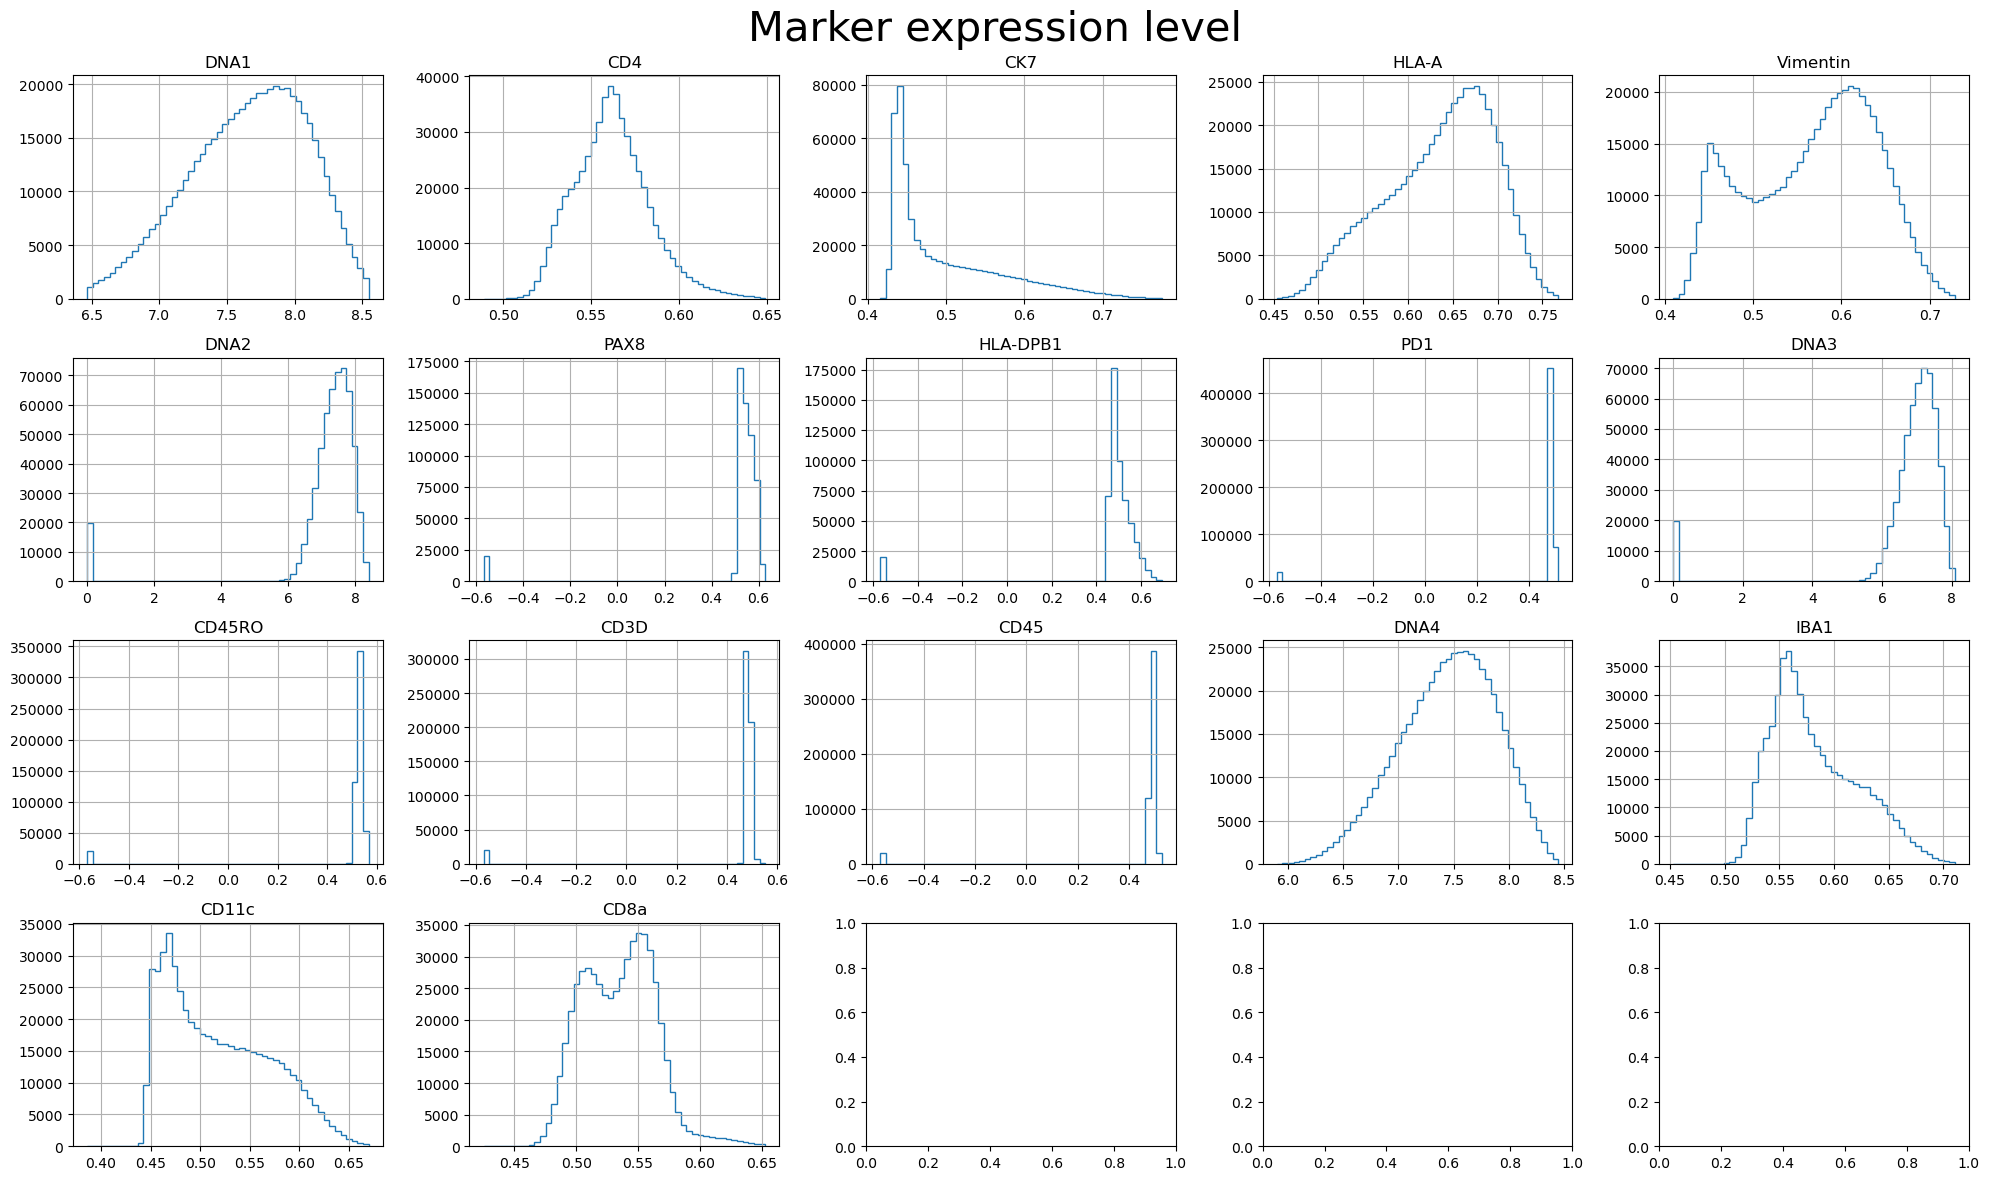

In [151]:
marker_expression(np.arcsinh(sample_data[cols]/5.0), markers=None, save=True, fname="{}/{}_marker_expression.png".format(output_path, sample_name), dpi='figure', log=False)
marker_expression(np.arcsinh(sample_data[cols]/5.0), markers=None, save=False, fname="{}/{}_marker_expression.png".format(output_path, sample_name), dpi='figure', log=False)

In [152]:
# read logic table
logic_table_name = "logic_table8"
df = pd.ExcelFile("{}/{}.xlsx".format(path, logic_table_name))
logic = pd.read_excel(df, df.sheet_names, index_col=0)

In [153]:
logic

{'Global':           Cancer  Stromal  CD4.T.cell  CD8.T.cell  CD11c.Myeloid  IBA1.Myeloid
 Marker                                                                        
 CK7            1       -1          -1          -1             -1            -1
 PAX8           1        0           0           0              0             0
 Vimentin      -1        1           0           0              0             0
 CD4            0       -1           1          -1             -1            -1
 CD8a           0       -1          -1           1             -1            -1
 IBA1           0        0           0           0              0             1
 CD11c          0        0           0           0              1             0}

# Run Tribus

In [154]:
# set random seed to ensure reproducity
depth = 1
labels, scores = tribus.run_tribus(np.arcsinh(sample_data[cols]/5.0), logic, depth=depth, normalization=z_score, 
                            tuning=0, sigma=1, learning_rate=1, 
                            clustering_threshold=100, undefined_threshold=0.0005, other_threshold=0.4, random_state=42)

Global, subsetting done
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 0.5785940295801937
2.3227710207303365 minutes


In [155]:
labels

,Global,final_label
0,Cancer,Cancer
1,Stromal,Stromal
2,Stromal,Stromal
3,Stromal,Stromal
4,CD4.T.cell,CD4.T.cell
...,...,...
556516,Stromal,Stromal
556517,Stromal,Stromal
556518,Cancer,Cancer
556519,Cancer,Cancer


# Visualization

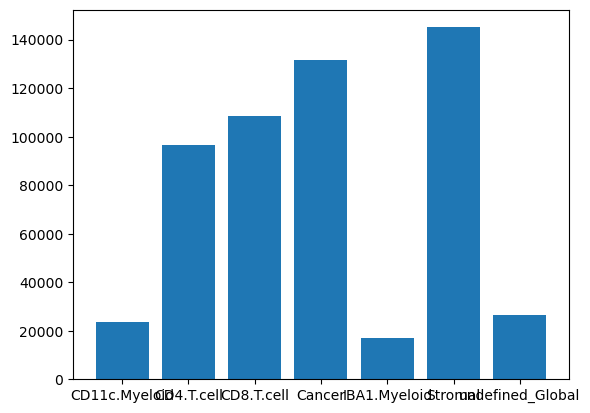

<Figure size 1600x700 with 0 Axes>

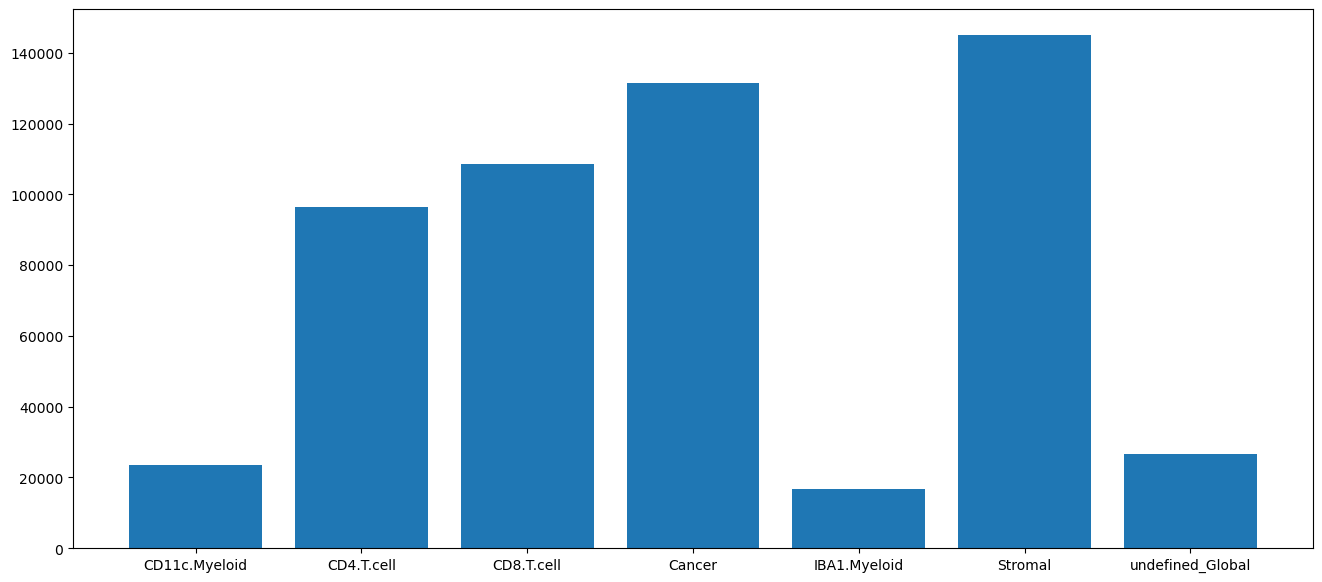

In [156]:
tribus.cell_type_distribution(labels, level="Global", save=False, fname=None, dpi="Figure")
plt.figure(figsize = (16,7))
tribus.cell_type_distribution(labels, level="final_label", save=True, fname="{}/{}_barplot.png".format(output_path, sample_name), dpi="Figure")
plt.figure(figsize = (16,7))
tribus.cell_type_distribution(labels, level="final_label", save=False, fname=None, dpi="Figure")

<Figure size 800x600 with 0 Axes>

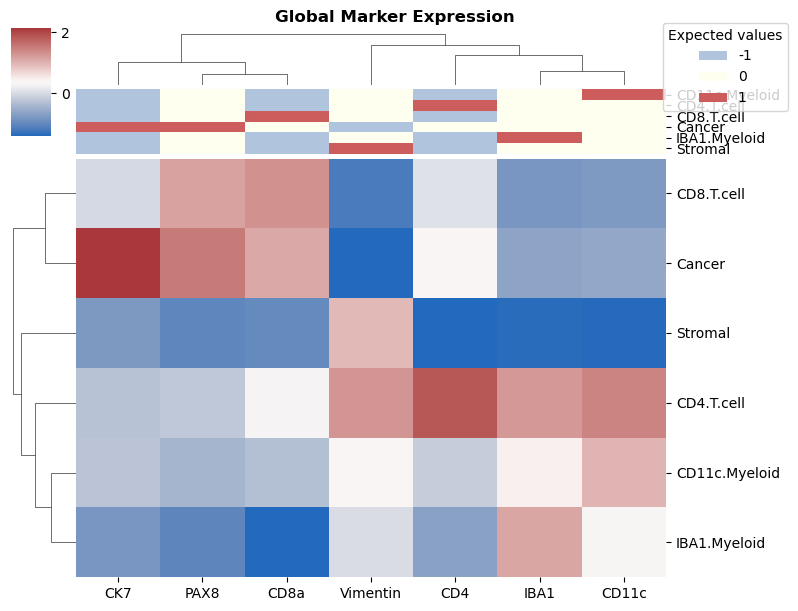

In [157]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=True, fname="{}/{}_heatmap.png".format(output_path, sample_name), 
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)
    
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False, fname="{}/{}_heatmap.png".format(output_path, sample_name), 
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

# Save the result

In [158]:
result_data = sample_data.join(labels)
labels_new = labels.join(result_data["CellID"])
labels_new.to_csv('{}/{}_{}_tribus_annotation.csv'.format(output_path, sample_name, logic_table_name))
result_data.to_csv('{}/{}_{}_raw_tribus_annotated.csv'.format(output_path, sample_name, logic_table_name))